In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from dynesty import utils as dyfunc
from dynesty import plotting_sequi2 as dyplot
from scipy.ndimage import gaussian_filter as norm_kde
import random

In [2]:
myrun='dsampler_pi=0.1_neff=10000_1000-events'

In [3]:
with open(myrun+'_results.pkl', 'rb') as handle:
    results = pickle.load(handle)
    
with open(myrun+'_my_results.pkl', 'rb') as handle:
    myresults = pickle.load(handle)

In [4]:
myresults['xtrue']

[114.55192220315759,
 14.579218540060001,
 124.98765788830707,
 2.2481061431735427,
 0.003917890843436221,
 0.030928635352682875,
 0.1]

In [5]:
means = [[myresults['xtrue_biased'][0],0.15*myresults['xtrue_biased'][0]], 
         [myresults['xtrue_biased'][1],0.15*myresults['xtrue_biased'][1]], 
         [myresults['xtrue_biased'][2],0.10*myresults['xtrue_biased'][2]], 
         [myresults['xtrue_biased'][3],0.15*myresults['xtrue_biased'][3]], 
         [myresults['xtrue_biased'][4],0.40*myresults['xtrue_biased'][4]], 
         [myresults['xtrue_biased'][5],0.40*myresults['xtrue_biased'][5]], 
         [0.5,0.5]]

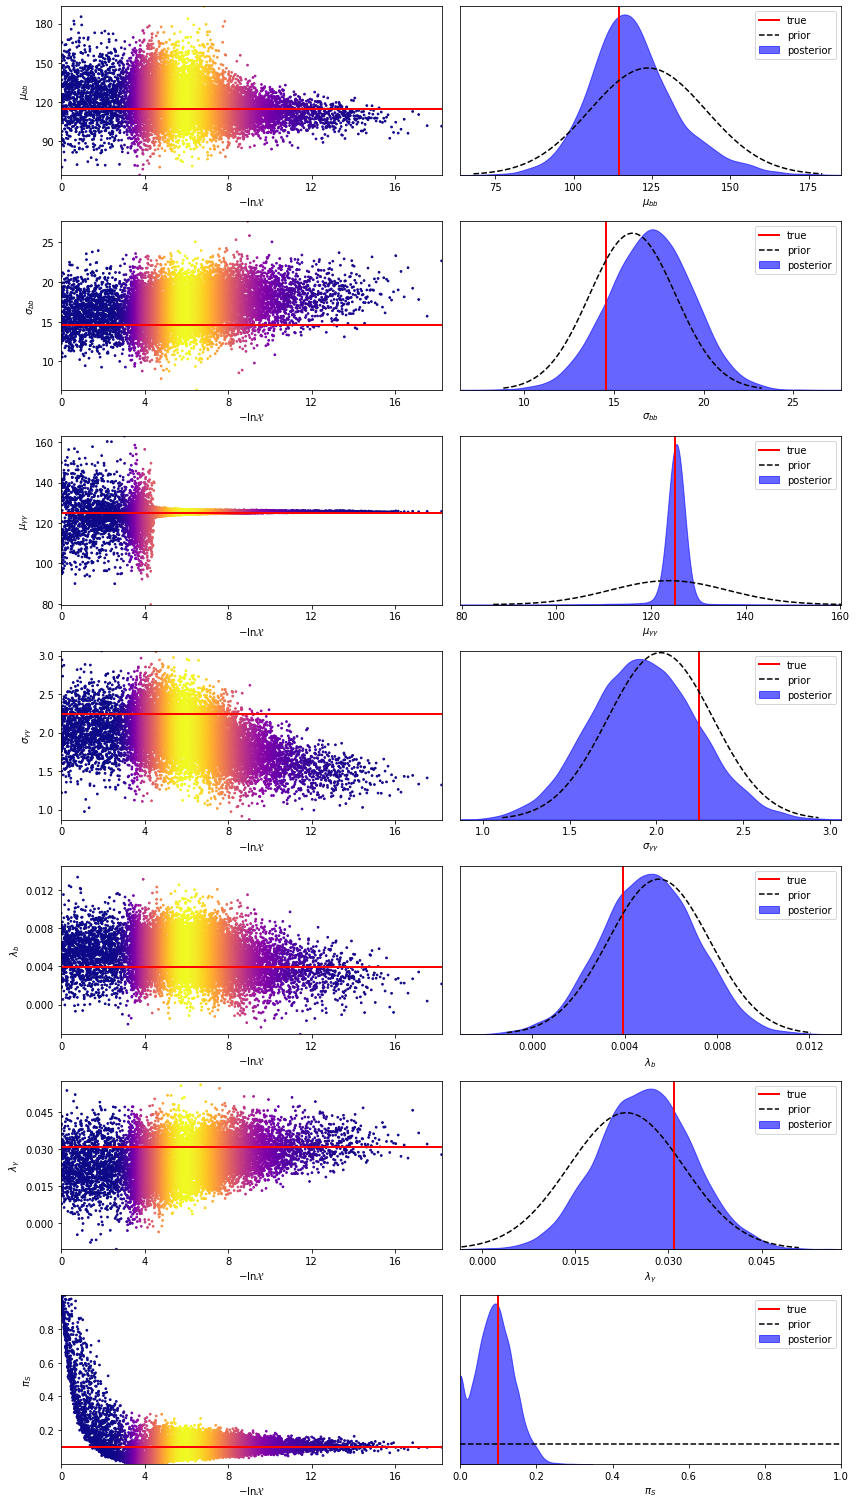

In [6]:
tfig2, taxes2 = dyplot.traceplot(results, post_color='blue', truths=myresults['xtrue'], means= means, quantiles=None, labels=['$\mu_{bb}$','$\sigma_{bb}$','$\mu_{\gamma\gamma}$','$\sigma_{\gamma\gamma}$','$\lambda_b$','$\lambda_\gamma$', '$\pi_S$'])

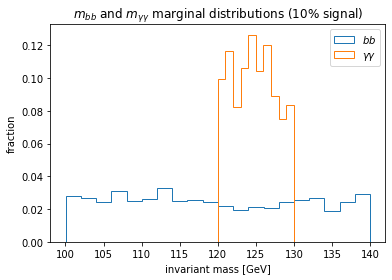

In [7]:
plt.hist([x[0] for x in myresults['X']],bins=20, density = 1, histtype='step', label='$bb$')
plt.hist([x[1] for x in myresults['X']],bins=10, density = 1, histtype='step', label = '$\gamma\gamma$')
plt.title('$m_{bb}$ and $m_{\gamma\gamma}$ marginal distributions (10% signal)')
plt.xlabel('invariant mass [GeV]')
plt.ylabel('fraction')
plt.legend()
#plt.savefig('/home/sequi/Documents/dihiggs/'+myrun+'_histogram.jpg')
plt.show()

In [8]:
len( myresults['X'])

1000

### Sample from posterior

Since version 1.7.0, NumPy has a choice function that supports probability distributions.

from numpy.random import choice
draw = choice(list_of_candidates, number_of_items_to_pick,
              p=probability_distribution)
              
Note that probability_distribution is a sequence in the same order of list_of_candidates. You can also use the keyword replace=False to change the behavior so that drawn items are not replaced.

In [9]:
from numpy.random import choice

Eminbb = 100.0
Eminaa = 120.0
Emaxbb = 140.0
Emaxaa = 130.0

In [10]:
weights = np.exp(results['logwt'] - results['logz'][-1])
#x = [x[6] for x in results['samples']]

In [11]:
mm = choice(range(len(weights)), 7000, p=weights)

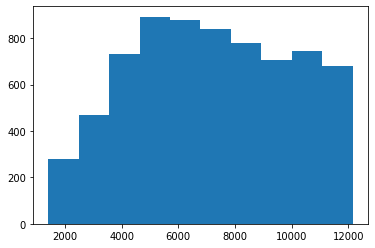

In [12]:
plt.hist(mm)
plt.show()

In [13]:
# few checks
k= 0
for i in range(5000):
    t = results['samples'][mm[i]].copy()
    if t[4]<0: k += 1 
k/5000

0.009

In [14]:
# mubb, sigmabb, muAA, sigmaAA, lambdabb, lambdaAA, pi
rep = []
for j in range(100):   # sample 10 times from each configuration
    #print(j)
    for i in range(5000):
        t = results['samples'][mm[i]].copy()
        #t[0] = 130 # mubb
        #t[1] = 2   # sigmabb
        #t[2] = 121 # muAA
        #t[3] = 1   # muAA
        #t[6] = 0.3
        #t[4] = t[4]*40 # lambda_bb
        #t[5] = t[5]*40 # lambda_bb
        if stats.binom.rvs(1,t[6])==1: # it is 1 (signal) every t[6] fraction
            # temporarily we assume everything is signal!!! We need a binomial sampling here
            mbb = stats.truncnorm.rvs((Eminbb-t[0])/t[1],(Emaxbb-t[0])/t[1], loc=t[0], scale=t[1]) 
            maa = stats.truncnorm.rvs((Eminaa-t[2])/t[3],(Emaxaa-t[2])/t[3], loc=t[2], scale=t[3])
            rep.append([mbb,maa,1])
        else:        
            mbb = stats.truncexpon.rvs((Emaxbb-Eminbb)*abs(t[4]), loc=Eminbb, scale=1/abs(t[4]))
            maa = stats.truncexpon.rvs((Emaxaa-Eminaa)*abs(t[5]), loc=Eminaa, scale=1/abs(t[5]))
            rep.append([mbb,maa,0])     

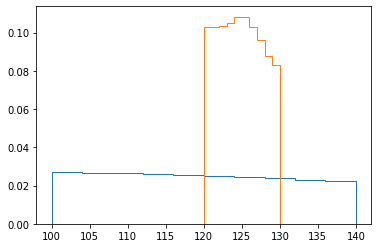

In [15]:
# Let's see the replicated data appearance
plt.hist([x[0] for x in rep], histtype='step', density=1, label='bb')
plt.hist([x[1] for x in rep], histtype='step', density=1, label='AA')
plt.show()

In [16]:
# Use 21 bins to have the first and last bin a round number
xbins = 20
ybins = 20
histogram = np.zeros([ybins,xbins], dtype=np.int32)
stepx = (Emaxbb-Eminbb)/xbins
stepy = (Emaxaa-Eminaa)/ybins
for i in range(len(rep)):
    binx = int((rep[i][0] - Eminbb) / stepx)
    biny = int((rep[i][1] - Eminaa) / stepy)
    histogram[biny][binx] += 1

In [17]:
# Compute the predictive check score
def predictive_score(mbb,maa):
    menor = 0
    mayor = 0
    mybinx = int((mbb - Eminbb) / stepx)
    mybiny = int((maa - Eminaa) / stepy)
    #print(mybinx,mybiny)
    mypdf = histogram[mybinx][mybiny]
    for i in range(ybins):
        for j in range(xbins):
            tmp = histogram[i][j]
            if  tmp > mypdf:
                #mayor += 1
                mayor += tmp
            else:
                #menor += 1
                menor += tmp
    return menor/(menor+mayor)
        

In [18]:
predictive_score(110,129)

0.213442

In [47]:
with open('X_heldout.txt', 'rb') as fp:
    X_held = pickle.load(fp)
X_held = random.sample(X_held, 200)

In [48]:
# How many signal events are there in the X_held sample
sum([x[2] for x in X_held])

25

In [49]:
score = []
for i in range(len(X_held)):
    score.append(predictive_score(X_held[i][0],X_held[i][1]))

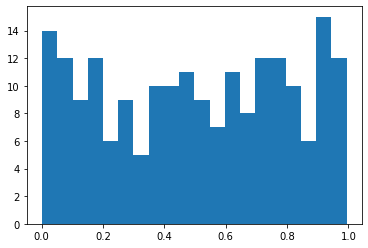

In [50]:
plt.hist(score, bins=20)
plt.show()

In [51]:
np.mean(score)

0.50558848

In [52]:
N=sum([sum(histogram[x]) for x in range(20)])

In [53]:
histogram_renormalized = histogram/N

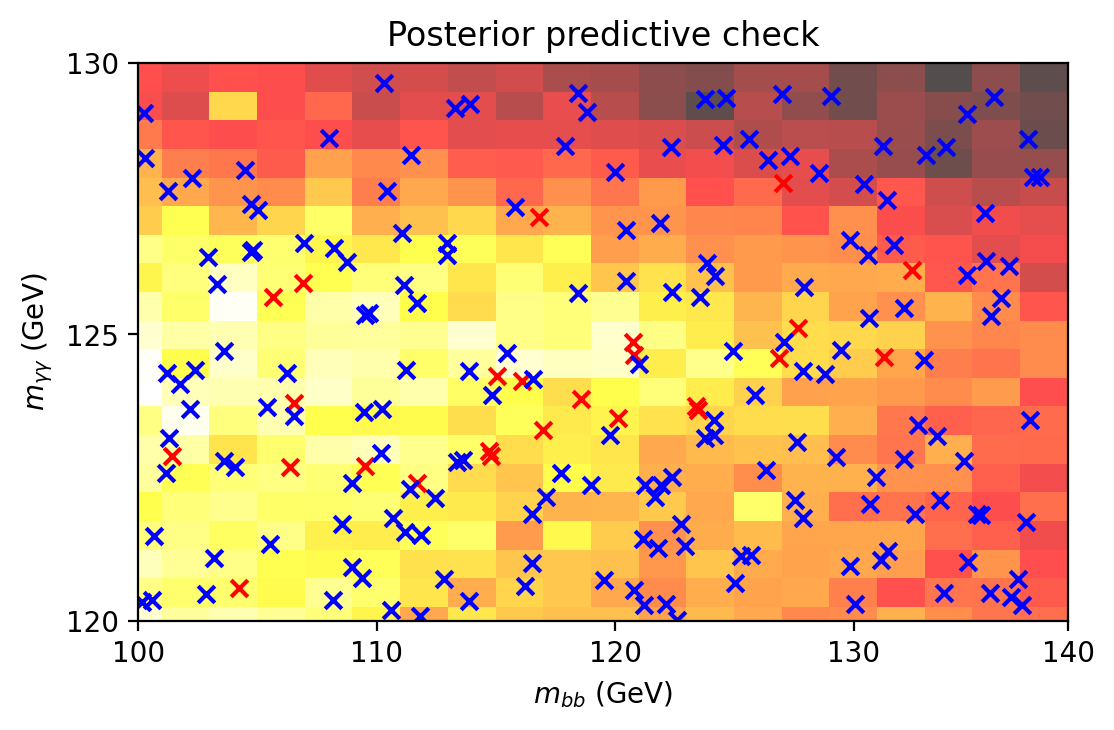

In [55]:
plt.figure(dpi=200)
plt.imshow(histogram_renormalized, cmap='hot', interpolation='nearest', alpha=0.7)
#plt.colorbar()
plt.scatter([(x[0]-100)*19/40 for x in X_held if x[2]==1],[(x[1]-120)*19/10 for x in X_held if x[2]==1],marker='x', color='red')
plt.scatter([(x[0]-100)*19/40 for x in X_held if x[2]==0],[(x[1]-120)*19/10 for x in X_held if x[2]==0],marker='x', color='blue')
plt.xlim(0,19.5)
plt.ylim(0,19.5)
plt.xticks([0,5,10,15,19.5],[100,110,120,130,140], rotation=0)
plt.yticks([0,10,19.5],[120,125,130])
plt.xlabel('$m_{bb}$ (GeV)')
plt.ylabel('$m_{\gamma\gamma}$ (GeV)')
plt.title('Posterior predictive check')
plt.gca().set_aspect(0.6)
plt.savefig('posterior_predictive.png', bbox_inches='tight')
plt.show()

In [38]:
flat_list = [item for sublist in histogram_renormalized for item in sublist]
min(flat_list), max(flat_list)

(0.001814, 0.003016)

#### Truncexp

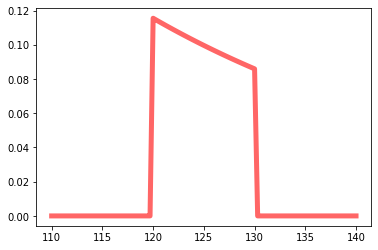

In [105]:
x = np.linspace(110,140,100)
b = 10*t[5]
plt.plot(x, stats.truncexpon.pdf(x, b, loc=120, scale=1/t[5]),'r-', lw=5, alpha=0.6, label='truncexpon pdf')
plt.show()